In [1]:
import os
import numpy as np
import pandas as pd

from itertools import groupby
from itertools import combinations

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.datasets.base import Bunch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans, MiniBatchKMeans

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
from util import Ean
ean_checker = Ean()

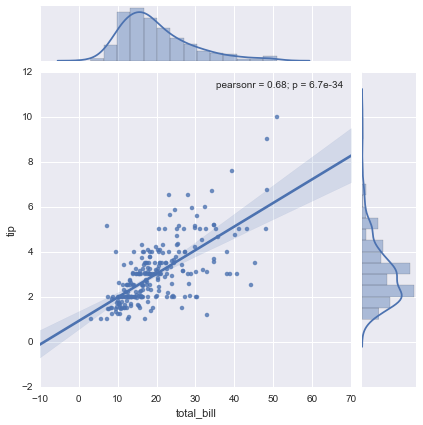

In [3]:
import seaborn as sns

# Load one of the data sets that come with seaborn
tips = sns.load_dataset("tips")

sns.jointplot("total_bill", "tip", tips, kind='reg');
 

In [4]:
def abs_dist(attr='price'):
    def _inner(a, b):
        return abs(a[attr] - b[attr])
    return _inner

In [5]:
def equal_dist(attr='name'):
    def _inner(a, b):
        if a[attr] == b[attr]:
            return 0.0
        else:
            return 1.0
    return _inner

In [6]:
class Distance:
    distances = [
        abs_dist(attr='price'),
        equal_dist(attr='name'),
    ]
    def __call__(self, a, b):
        distances = []
        for distance in self.distances:
            distances.append(distance(a, b))
        return np.array(distances)

## clean up prices

In [7]:
def convert_price(price):
    price = str(price)
    if ',' in price:
        if '.' in price:
            price = price.replace('.', '')
        price = price.replace(',', '.')
        
    if ' EUR' in price:
        price = price.replace(' EUR', '')

    try:
        return float(price)
    except ValueError:
        # print('<{}>'.format(price))
        return None

## read products feed

In [8]:
products = pd.read_csv('products.csv', error_bad_lines=False, converters={'price': convert_price})
products = products.drop('Unnamed: 0', 1)
products = products[~products.price.isnull()]
# list(products.columns)

//anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## group by ean and get samples with at least 5 items

In [9]:
# dunno why this is so slow
# ean_grouped = products.groupby('ean').filter(lambda x: len(x) > 5)

In [10]:
good_eans = pd.Series(ean for ean, eans in groupby(products.ean) if len(list(eans)) > 5)
sample_products = products[products.ean.isin(good_eans.sample(n=10))]

## create sample dataset

In [11]:
dataset = Bunch()
dataset.data = sample_products
dataset.target = sample_products.ean
dataset.true_k = np.unique(dataset.target).shape[0]

## feature extraction

In [18]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        values = np.array(df[self.key])
        return values.reshape(values.shape[0], 1)

In [19]:
class TextExtractor(BaseEstimator, TransformerMixin):
    """Extract the text from a product in a single pass.

    Takes a pandas dataframe and produces a series of texts
    from joined columns defined in `text_cols`.
    """
    def __init__(self, text_cols=['name', 'shortdescription', 'brand', 'type']):
        self.text_cols = text_cols
    
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        def join(items):
            return ' '.join([str(item) for item in items])
        
        texts = data[self.text_cols].apply(join, axis=1)
        return texts

In [20]:
feature_union = FeatureUnion(
    transformer_list=[

        # Pipeline for pulling features from the text columns
        ('text_tfidf', Pipeline([
            # Extract text data from products
            ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
            ('tfidf', TfidfVectorizer()),
            ('svd', TruncatedSVD(2)),
            ('normalizer', Normalizer(copy=False)),
        ])),

        # Pipeline for price
        ('price', Pipeline([
            ('selector', ItemSelector(key='price')),
        ])),
    ],
)

In [21]:
X = feature_union.fit_transform(dataset.data, dataset.target)

In [22]:
sproducts = dataset.data.copy()

In [23]:
X[:, 1][:10]

array([-0.99904112, -0.99590531,  0.98601617, -0.98582691, -0.98485785,
        0.99625523,  0.99163131, -0.97872763,  0.01216516,  0.37496958])

In [24]:
sproducts['text_1'] = X[:, 0]
sproducts['text_2'] = X[:, 1]

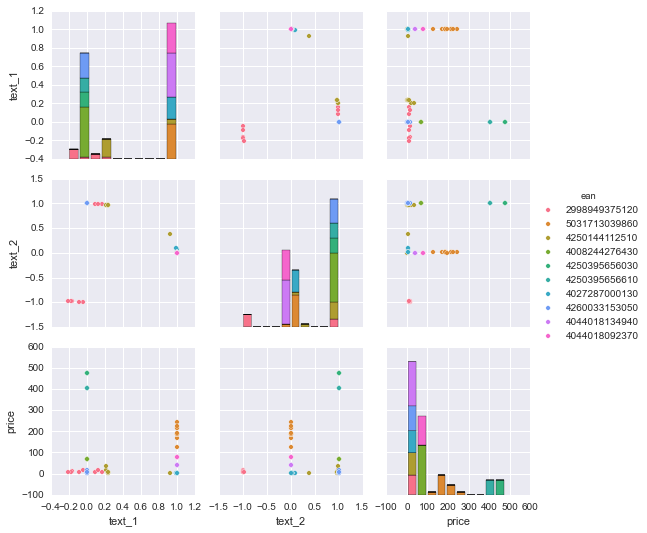

In [25]:
pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

In [ ]:
feature_union = FeatureUnion(
    transformer_list=[

        # Pipeline for pulling features from the text columns
        # and build a cosine distance matrix from it
        ('text_tfidf', Pipeline([
            # Extract text data from products
            ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
            ('tfidf', TfidfVectorizer()),
            ('tfidf_distance', CosineDistance()),
        ])),

        # Pipeline for price
        ('price', Pipeline([
            ('selector', ItemSelector(key='price')),
            ('price_distance', NumericDistance()),
        ])),
    ],
)

In [26]:
pipeline = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('union', feature_union),
    # Use kmeans clustering on the combined features
    #('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [27]:
pipeline.fit(dataset.data, dataset.target)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('text_tfidf', Pipeline(steps=[('text', TextExtractor(text_cols=['name', 'brand', 'type'])), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, m...er(copy=False, norm='l2'))])), ('price', Pipeline(steps=[('selector', ItemSelector(key='price'))]))],
       transformer_weights=None))])

In [28]:
X = pipeline.transform(dataset.data)

In [29]:
X.shape

(112, 3)

In [136]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [137]:
%%javascript
element.append("<div id='chart1'></div>");


<IPython.core.display.Javascript object>

In [138]:
from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript("""
           window.vizObj={};
           """.format(sproducts.to_json()))

<IPython.core.display.Javascript object>

## vectorize dataset

In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataset.data)

In [14]:
X.shape

(8, 8)

In [16]:
distance = Distance()
distances = []
for a, b in combinations(data, 2):
    distances.append(distance(a, b))
len(distances)

NameError: name 'data' is not defined

## actual clustering

In [20]:
true_k = np.unique(dataset.target).shape[0]

In [21]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)

In [22]:
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=11, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [23]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.664
Completeness: 0.683
V-measure: 0.673
Adjusted Rand-Index: 0.384
Silhouette Coefficient: 0.124


In [24]:
km.labels_

array([10,  1,  1,  1,  3,  1,  3, 10,  1,  1,  1,  3,  1,  3, 10, 10,  3,
        1,  1,  1,  3,  3,  1,  1,  3,  1,  3,  8,  8,  8,  8,  8,  3,  9,
        9,  9,  9,  9,  9,  2,  2,  2,  2,  2,  2,  9,  7,  7,  5,  7,  5,
        7,  9,  7,  3,  7,  0,  0,  0,  0,  0,  0,  0,  6,  6,  5,  5,  6,
        6,  4,  6,  4,  2,  4,  5,  5,  6,  6], dtype=int32)

In [25]:
np.array(labels)

array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9, 10, 10, 10, 10, 10, 10, 10])

In [27]:
km.cluster_centers_

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04313126,  0.01632048,  0.        , ...,  0.01687808,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.03065984,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.05609483,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.04888626, ...,  0.0779779 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## dimension reduction

In [28]:
svd = TruncatedSVD(2)
normalizer = Normalizer(copy=False)

In [29]:
lsa = make_pipeline(svd, normalizer)

In [30]:
X = lsa.fit_transform(X)

In [31]:
X.shape

(78, 2)

In [32]:
X[:10]

array([[ 0.74746833,  0.66429744],
       [ 0.87252354,  0.48857208],
       [ 0.86923716,  0.49439534],
       [ 0.85150565,  0.52434542],
       [ 0.74831437,  0.66334426],
       [ 0.83653341,  0.54791592],
       [ 0.89304456,  0.44996823],
       [ 0.73481831,  0.678264  ],
       [ 0.81475945,  0.57979913],
       [ 0.88670099,  0.46234332]])

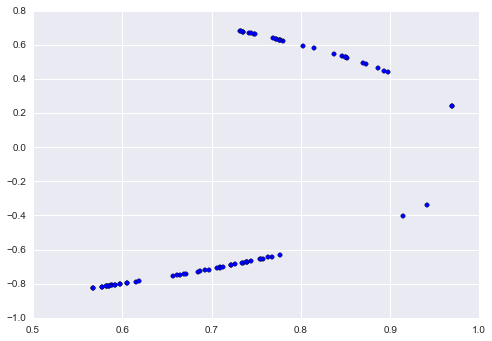

In [35]:
plt.scatter(X[:, 0], X[:, 1])